In [1]:
%pylab inline

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import tailer
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
factors = ["BHLHE40", "CEBPB", "CTCF", "E2F4", "EBF1", "ELF1", "ELK1", "ETS1", "FOS", "IRF4", "JunD", "Max", "MEF2A", "MEF2C", "Mxi1", "NFIC", "NFKB", "NFYA", "NFYB", "Nrf1", "NRSF", "PAX5", "PBX3", "POU2F2", "PU1", "RFX5", "RUNX3", "SP1", "SRF", "STAT1", "STAT3", "TCF3", "USF1", "USF2", "YY1", "ZBTB33", "ZEB1", "Znf143"]
rank_perc = [950, 990, 995]

In [3]:
factordata = {}
DIR="/storage/pandaman/project/singletons/AgentBind/"
for f in factors:
    # load data
    fdata = pd.read_csv(os.path.join(DIR, f, "factor_singletons_r2.tab"), sep="\t", skiprows=1,
                            names=["chrom","start", "end", "ref", "AC", "AN",
                                   "raw.score","snr.score","rank","core"])
    fdata = fdata[~np.isnan(fdata["raw.score"])]
    fdata = fdata[~np.isnan(fdata["snr.score"])]
    fdata["factor"] = f
    factordata[f] = fdata
    print (f)

BHLHE40
CEBPB
CTCF
E2F4
EBF1
ELF1
ELK1
ETS1
FOS
IRF4
JunD
Max
MEF2A
MEF2C
Mxi1
NFIC
NFKB
NFYA
NFYB
Nrf1
NRSF
PAX5
PBX3
POU2F2
PU1
RFX5
RUNX3
SP1
SRF
STAT1
STAT3
TCF3
USF1
USF2
YY1
ZBTB33
ZEB1
Znf143


In [4]:
for f in factors:
    factordata[f]["sing"] = (factordata[f]["AC"] == 1) | \
        ((factordata[f]["AN"] - factordata[f]["AC"]) == 1)

In [5]:
print (factordata["FOS"])

     chrom     start       end ref    AC     AN     raw.score  snr.score  \
0     chr1   6844149   6844150   G     3  10874  1.446875e-07   0.015152   
1     chr1   6844156   6844157   A     1  10880  2.634950e-07   0.027595   
2     chr1   6844205   6844206   T     3  10878  2.952045e-07   0.030915   
3     chr1   6844244   6844245   A    28  10866  1.045970e-06   0.109539   
4     chr1   6844259   6844260   C     2  10874  5.067173e-06   0.530660   
5     chr1   6844347   6844348   C     1  10874  3.301959e-06   0.345798   
6     chr1   6844363   6844364   C     2  10880  3.772347e-07   0.039506   
7     chr1   6844369   6844370   C   156  10872  1.477281e-06   0.154708   
8     chr1   6844408   6844409   C     1  10834  1.484773e-06   0.155493   
9     chr1   6844434   6844435   T     3  10790  0.000000e+00   0.000000   
10    chr1   6844442   6844443   G     9  10856  2.112909e-06   0.221275   
11    chr1   6844484   6844485   G     3  10842  2.276528e-06   0.238410   
12    chr1  

In [10]:
data = []

for f in factors:
    d = []
    fd = factordata[f]
    
    # Get pval for core
    p_all = np.mean(fd["sing"])
    p_core = np.mean(fd[fd["core"]>0]["sing"])
    n_all = fd.shape[0]
    n_core = fd[fd["core"]>0].shape[0]
    d = [f, p_all, p_core, n_all, n_core]
    n_not_core = n_all-n_core
    p_not_core = (p_all*n_all-p_core*n_core)/(n_not_core)
    se_core = np.sqrt(p_all*(1-p_all)*(1.0/n_core+1.0/n_not_core))
    pval_core = 1-scipy.stats.norm.cdf((p_core-p_not_core)/se_core)
    d.append(pval_core)
    
    for i in range(len(rank_perc)):
        rk = (fd[fd["rank"]>=rank_perc[i]]["sing"])
        p_rk = np.mean(rk)
        diff_p_rk = p_rk - p_all
        err_rk = np.sqrt(p_rk*(1-p_rk)/len(rk))
        n_rk = len(rk)
        n_not_rk = n_all-n_rk
        p_not_rk = (p_all*n_all-np.sum(rk))*1.0/n_not_rk
        # Compute pvals
        se_rk = np.sqrt(p_all*(1-p_all)*(1.0/n_rk+1.0/n_not_rk))
        pval_rk = 1-scipy.stats.norm.cdf((p_rk-p_not_rk)/se_rk)
        # Add data
        d.extend([p_rk, diff_p_rk, err_rk, pval_rk, len(rk)])
    data.append(d)

cols = ["factor","sing.all","sing.core","n.all","n.core","pval.core"]
for i in range(len(rank_perc)):
    cols.extend(["sing.rank.%s"%rank_perc[i], "diff.rank.%s"%rank_perc[i], 
                 "sing.rank.%s.err"%rank_perc[i], "pval.rank.%s"%rank_perc[i],
                "num.%s"%rank_perc[i]])
results = pd.DataFrame(data, columns=cols)
results["sing.all.err"] = results.apply(lambda x: np.sqrt(x["sing.all"]*(1-x["sing.all"])/x["n.all"]), 1)
results["sing.core.err"] = results.apply(lambda x: np.sqrt(x["sing.core"]*(1-x["sing.core"])/x["n.core"]), 1)

In [11]:
list(results.columns)

['factor',
 'sing.all',
 'sing.core',
 'n.all',
 'n.core',
 'pval.core',
 'sing.rank.950',
 'diff.rank.950',
 'sing.rank.950.err',
 'pval.rank.950',
 'num.950',
 'sing.rank.990',
 'diff.rank.990',
 'sing.rank.990.err',
 'pval.rank.990',
 'num.990',
 'sing.rank.995',
 'diff.rank.995',
 'sing.rank.995.err',
 'pval.rank.995',
 'num.995',
 'sing.all.err',
 'sing.core.err']

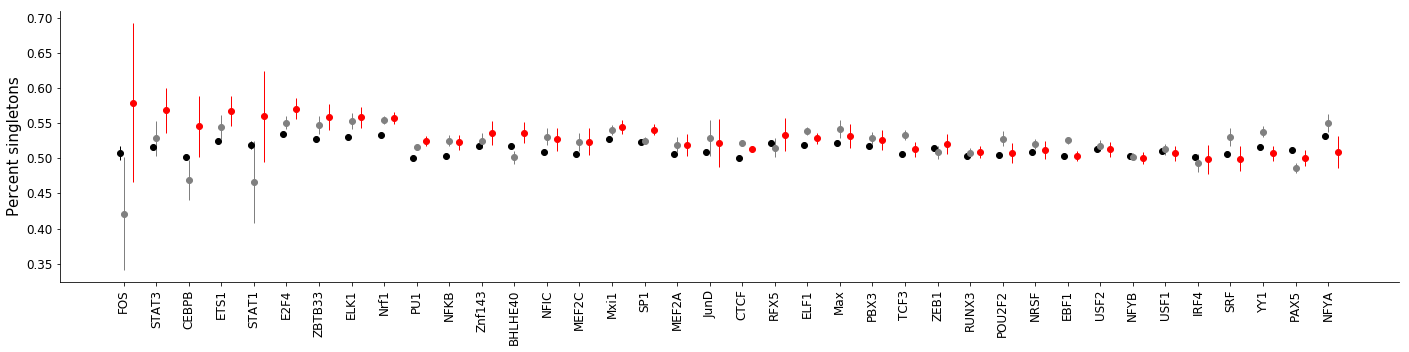

In [12]:
results = results.sort_values("diff.rank.995", ascending=False)
xvals = np.array(range(results.shape[0]))

w = 0.1
fig = plt.figure()
fig.set_size_inches((24, 5))
ax = fig.add_subplot(111)
ax.errorbar(xvals, results["sing.all"], label="All", yerr=results["sing.all.err"], marker="o", linewidth=0, elinewidth=1, color="black")
ax.errorbar(xvals+w, results["sing.core"], label="core", yerr=results["sing.core.err"], marker="o", linewidth=0, elinewidth=1, color="gray")
lab = True
for i in [2]:
    x = rank_perc[i]
    if not lab:
        lab = "Rank"
    else:
        lab = ""
    ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="red")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals+w)
ax.set_xticklabels(results["factor"], rotation=90, size=12);
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12)
#ax.legend(loc="upper left")
ax.set_ylabel("Percent singletons", size=15);

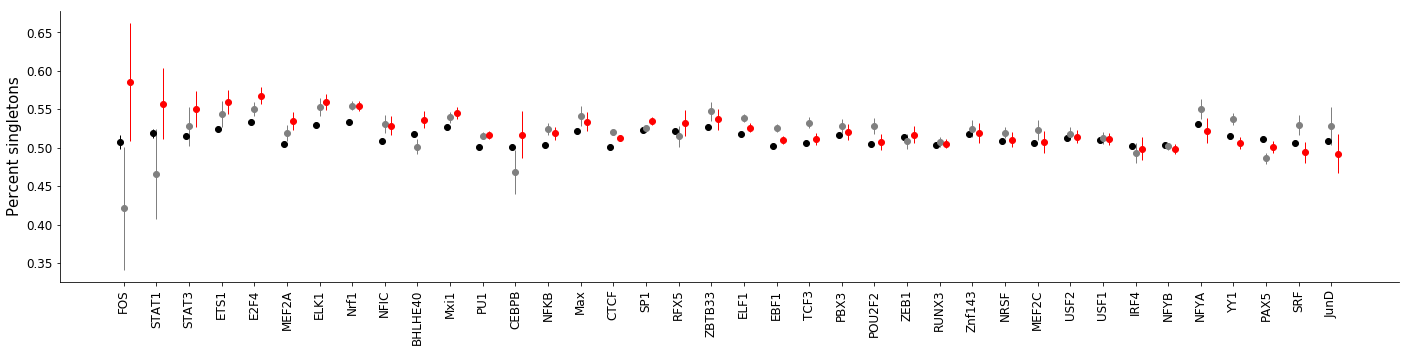

In [13]:
results = results.sort_values("diff.rank.990", ascending=False)
xvals = np.array(range(results.shape[0]))

w = 0.1
fig = plt.figure()
fig.set_size_inches((24, 5))
ax = fig.add_subplot(111)
ax.errorbar(xvals, results["sing.all"], label="All", yerr=results["sing.all.err"], marker="o", linewidth=0, elinewidth=1, color="black")
ax.errorbar(xvals+w, results["sing.core"], label="core", yerr=results["sing.core.err"], marker="o", linewidth=0, elinewidth=1, color="gray")
lab = True
for i in [1]:
    x = rank_perc[i]
    if not lab:
        lab = "Rank"
    else:
        lab = ""
    ax.errorbar(xvals+w*(2+i), results["sing.rank.%s"%x], label=lab, yerr=results["sing.rank.%s.err"%x], marker="o", linewidth=0, elinewidth=1, color="red")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_xticks(xvals+w)
ax.set_xticklabels(results["factor"], rotation=90, size=12);
ax.set_yticklabels(["%0.2f"%item for item in ax.get_yticks()], size=12)
#ax.legend(loc="upper left")
ax.set_ylabel("Percent singletons", size=15);

In [14]:
results_greater = results[results["sing.rank.950"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.950","sing.all"]])

28
     factor  sing.rank.950  sing.all
0   BHLHE40       0.522319  0.517967
2      CTCF       0.500773  0.500505
3      E2F4       0.550039  0.533711
4      EBF1       0.504245  0.502538
5      ELF1       0.524295  0.518138
6      ELK1       0.537982  0.529899
7      ETS1       0.529706  0.524732
8       FOS       0.548718  0.507340
12    MEF2A       0.507827  0.505426
11      Max       0.532256  0.522114
14     Mxi1       0.529607  0.527251
15     NFIC       0.515193  0.508712
17     NFYA       0.533586  0.531145
19     Nrf1       0.541878  0.532890
22     PBX3       0.518897  0.516733
23   POU2F2       0.505400  0.504661
24      PU1       0.501871  0.500689
25     RFX5       0.530000  0.521613
26    RUNX3       0.503339  0.503292
27      SP1       0.530854  0.523159
29    STAT1       0.543750  0.518643
30    STAT3       0.528809  0.515856
31     TCF3       0.509736  0.506568
32     USF1       0.511519  0.510356
33     USF2       0.515612  0.513102
34      YY1       0.516604  0.51596

In [15]:
results_greater = results[results["sing.rank.990"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.990","sing.all"]])

31
     factor  sing.rank.990  sing.all
0   BHLHE40       0.536691  0.517967
1     CEBPB       0.516981  0.501229
2      CTCF       0.512147  0.500505
3      E2F4       0.567404  0.533711
4      EBF1       0.510257  0.502538
5      ELF1       0.526338  0.518138
6      ELK1       0.559338  0.529899
7      ETS1       0.559237  0.524732
8       FOS       0.585366  0.507340
12    MEF2A       0.535297  0.505426
13    MEF2C       0.507740  0.506062
11      Max       0.533981  0.522114
14     Mxi1       0.544811  0.527251
15     NFIC       0.528694  0.508712
16     NFKB       0.518699  0.502973
20     NRSF       0.510220  0.508248
19     Nrf1       0.554024  0.532890
22     PBX3       0.520639  0.516733
23   POU2F2       0.507979  0.504661
24      PU1       0.516719  0.500689
25     RFX5       0.532164  0.521613
26    RUNX3       0.505555  0.503292
27      SP1       0.534560  0.523159
29    STAT1       0.557522  0.518643
30    STAT3       0.550756  0.515856
31     TCF3       0.511438  0.50656

In [16]:
results_greater = results[results["sing.rank.995"] > results["sing.all"]].sort_values("factor")
print (results_greater.shape[0])
print (results_greater[["factor","sing.rank.995","sing.all"]])

30
     factor  sing.rank.995  sing.all
0   BHLHE40       0.536258  0.517967
1     CEBPB       0.545455  0.501229
2      CTCF       0.512755  0.500505
3      E2F4       0.570370  0.533711
4      EBF1       0.503316  0.502538
5      ELF1       0.528141  0.518138
6      ELK1       0.558099  0.529899
7      ETS1       0.567325  0.524732
8       FOS       0.578947  0.507340
10     JunD       0.521531  0.508286
12    MEF2A       0.518820  0.505426
13    MEF2C       0.523673  0.506062
11      Max       0.531144  0.522114
14     Mxi1       0.544764  0.527251
15     NFIC       0.526906  0.508712
16     NFKB       0.522759  0.502973
20     NRSF       0.511232  0.508248
19     Nrf1       0.556935  0.532890
22     PBX3       0.525672  0.516733
23   POU2F2       0.507871  0.504661
24      PU1       0.524211  0.500689
25     RFX5       0.533333  0.521613
26    RUNX3       0.508691  0.503292
27      SP1       0.540611  0.523159
29    STAT1       0.559322  0.518643
30    STAT3       0.567901  0.51585

for method in ("AgentBind",):
    for f in factors:
        subset = factordata[method][f][factordata[method][f]["AN"] > 8000]
        print ("%s:%d,%d" %(f, factordata[method][f].shape[0], subset.shape[0]))

In [17]:
results[["factor","pval.rank.950","pval.rank.990","pval.rank.995"]]

,factor,pval.rank.950,pval.rank.990,pval.rank.995
8,FOS,0.115392,0.157029,0.265506
29,STAT1,0.127527,0.202280,0.265051
30,STAT3,0.098176,0.065367,0.051736
7,ETS1,0.237168,0.014022,0.021630
3,E2F4,0.000612,0.001184,0.007606
12,MEF2A,0.321356,0.005408,0.199743
6,ELK1,0.047955,0.003125,0.027907
19,Nrf1,0.001267,0.000496,0.002627
15,NFIC,0.116040,0.051890,0.137795
0,BHLHE40,0.182194,0.042569,0.109826


In [18]:
# calculate overall p-value
fd = pd.concat(factordata.values())

cols = ["factor","sing.all","sing.core","n.all","n.core","pval.core"]
for i in range(len(rank_perc)):
    cols.extend(["sing.rank.%s"%rank_perc[i], "sing.rank.%s.err"%rank_perc[i], "pval.rank.%s"%rank_perc[i],
                 "num.%s"%rank_perc[i]])
data = []


p_all = np.mean(fd["sing"])
p_core = np.mean(fd[fd["core"]>0]["sing"])
n_all = fd.shape[0]
n_core = fd[fd["core"]>0].shape[0]
d = ["ALL", p_all, p_core, n_all, n_core]

# Get pval for core
n_not_core = n_all-n_core
p_not_core = (p_all*n_all-p_core*n_core)/(n_not_core)
se_core = np.sqrt(p_all*(1-p_all)*(1.0/n_core+1.0/n_not_core))
pval_core = 1-scipy.stats.norm.cdf((p_core-p_not_core)/se_core)
d.append(pval_core)
    
for i in range(len(rank_perc)):
    rk = (fd[fd["rank"]>=rank_perc[i]]["sing"])
    p_rk = np.mean(rk)
    err_rk = np.sqrt(p_rk*(1-p_rk)/len(rk))
    n_rk = len(rk)
    n_not_rk = n_all-n_rk
    p_not_rk = (p_all*n_all-np.sum(rk))*1.0/n_not_rk
    # Compute pvals
    se_rk = np.sqrt(p_all*(1-p_all)*(1.0/n_rk+1.0/n_not_rk))
    pval_rk = 1-scipy.stats.norm.cdf((p_rk-p_not_rk)/se_rk)
    # Add data
    d.extend([p_rk, err_rk, pval_rk, len(rk)])
data.append(d)

result_all = pd.DataFrame(data, columns=cols)
result_all["sing.all.err"] = result_all.apply(lambda x: np.sqrt(x["sing.all"]*(1-x["sing.all"])/x["n.all"]), 1)
result_all["sing.core.err"] = result_all.apply(lambda x: np.sqrt(x["sing.core"]*(1-x["sing.core"])/x["n.core"]), 1)

In [19]:
result_all.transpose()

,0
factor,ALL
sing.all,0.50969
sing.core,0.523063
n.all,9099752
n.core,173897
pval.core,0
sing.rank.950,0.512317
sing.rank.950.err,0.000628794
pval.rank.950,7.42184e-06
num.950,631917


In [20]:
print ((results["diff.rank.950"]).sum()/38.0)
print ((results["diff.rank.990"]).sum()/38.0)
print ((results["diff.rank.995"]).sum()/38.0)

0.003376979780703063
0.011442593858275537
0.014868492333872668
